In [117]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
lines = ['WT', 'her1', 'her7', 'loop']
conditions = {
    '_c': 'Control',
    '_35': '35°C',
    '_37': '37°C',
    '_39': '39°C'
}

dfs = []  # to store all imported sheets

for line in lines:
    for cond_suffix, cond_name in conditions.items():
        sheet_name = f"{line}{cond_suffix}"
        
        try:
            df = pd.read_excel('Her_mutants.xlsx', sheet_name=sheet_name)
        except Exception:
            print(f"Skipping missing sheet: {sheet_name}")
            continue
        
        # Insert metadata columns at the start
        df.insert(0, 'Line', line)
        df.insert(1, 'Condition', cond_name)
        
        df = df[~df['ID'].isin(['Average', 'Mean', 'Median', 'Mode', 'Std dev'])]

        dfs.append(df)
        # Remove any lines with NaNs in the rows
        dfs[-1] = dfs[-1].dropna()


# Concatenate all clean sheets
all_data = pd.concat(dfs, ignore_index=True)


Skipping missing sheet: her7_37


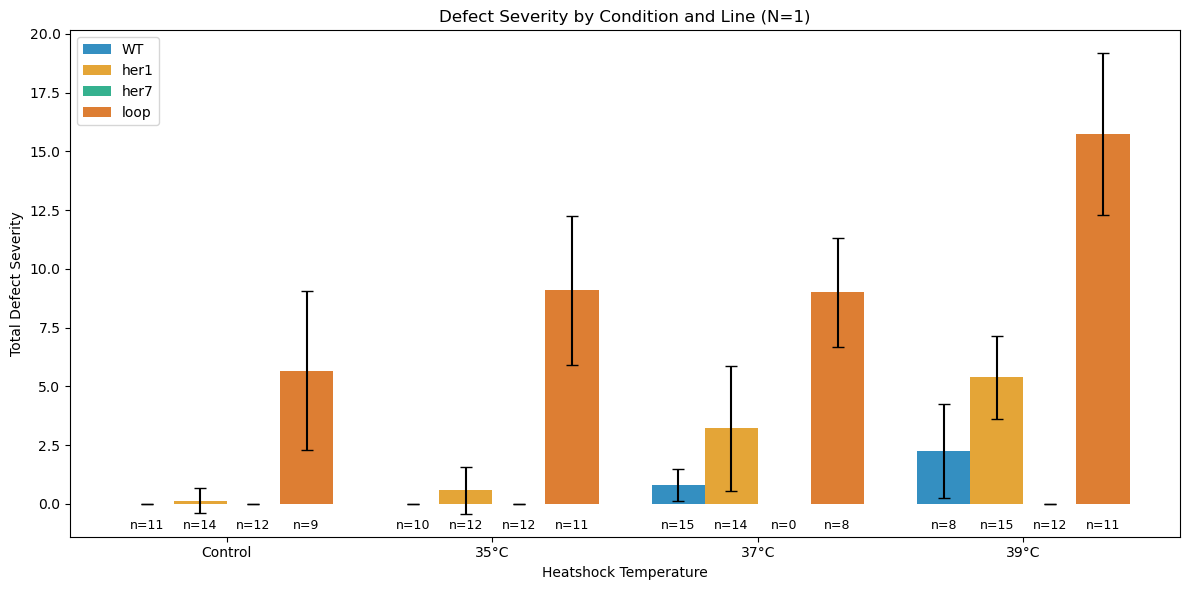

In [120]:
conditions = all_data['Condition'].unique()
lines = ['WT', 'her1', 'her7', 'loop']
colors = sns.color_palette("colorblind", n_colors=4)
# X positions for the groups (conditions)
x = np.arange(len(conditions))

# Width of each bar inside the group
width = 0.2

plt.figure(figsize=(12, 6))

for i, line in enumerate(lines):
    subset = all_data[all_data['Line'] == line]
    
    # Compute statistics in same condition order
    means = subset.groupby('Condition')['total'].mean().reindex(conditions)
    stds = subset.groupby('Condition')['total'].std().reindex(conditions)
    counts = subset.groupby('Condition')['total'].count().reindex(conditions).fillna(0)

    xs = x + i * width - width * 1.5

    # Shift each line’s bar group to the left or right
    bars = plt.bar(
        xs,
        means,
        yerr=stds,
        width=width,
        color=colors[i],
        alpha=0.8,
        label=line,
        capsize=4
    )
    # Add embryo counts below bars
    for bar, count in zip(bars, counts):
        height = -1.2
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"n={count:.0f}",
            ha='center',
            va='bottom',
            fontsize=9,
        )
plt.xticks(x, conditions)
plt.xlabel('Heatshock Temperature')
plt.ylabel('Total Defect Severity')
plt.title('Defect Severity by Condition and Line (N=1)')
plt.legend()
plt.tight_layout()
plt.savefig('defect_severity_barplot.png', dpi=600)
plt.show()

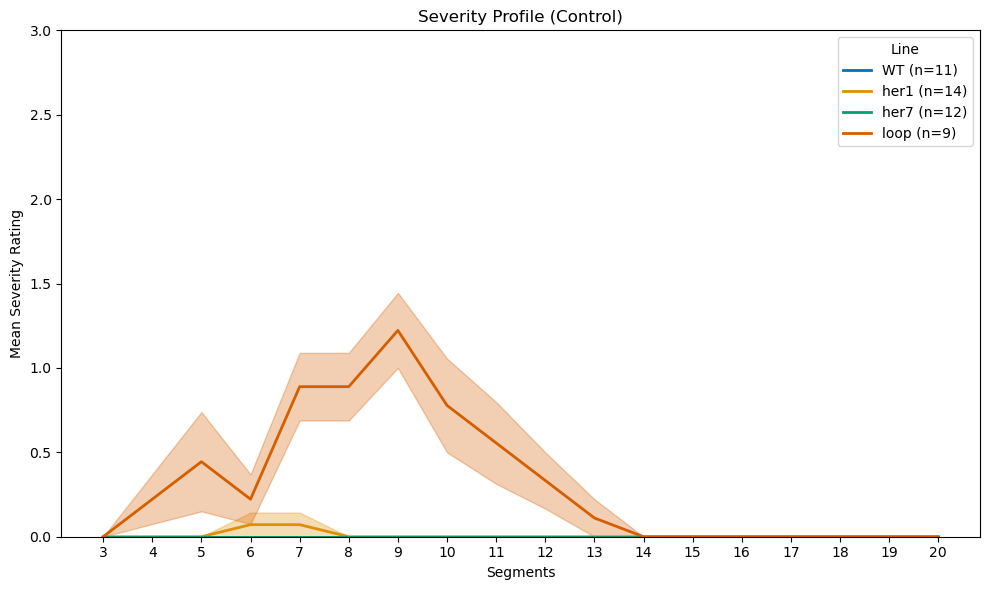

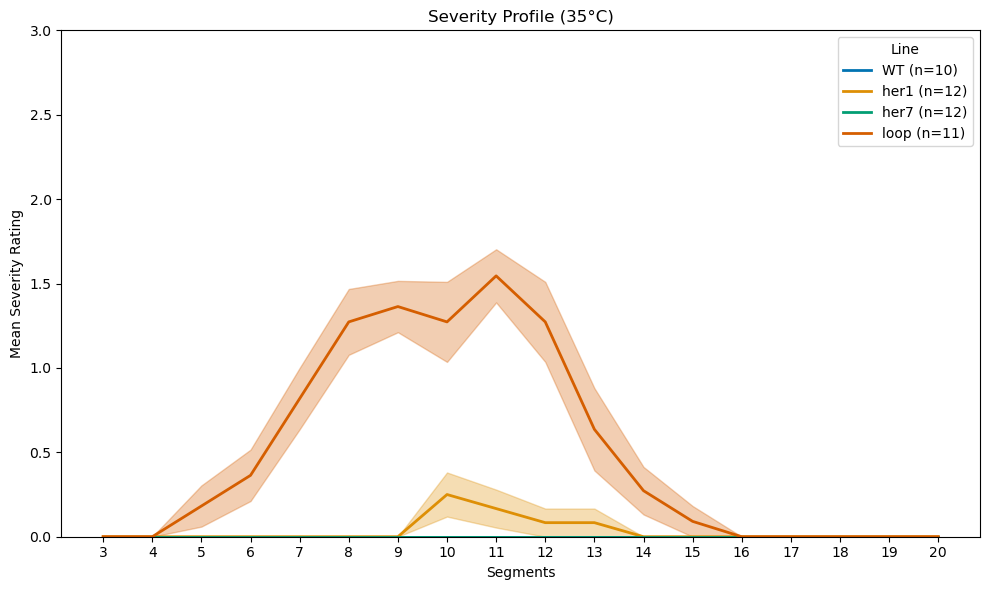

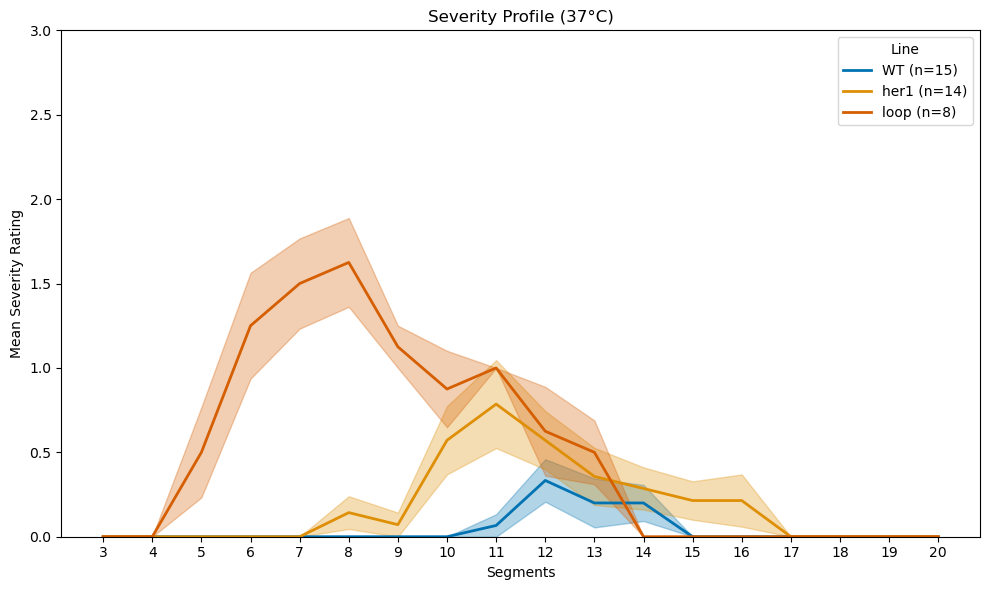

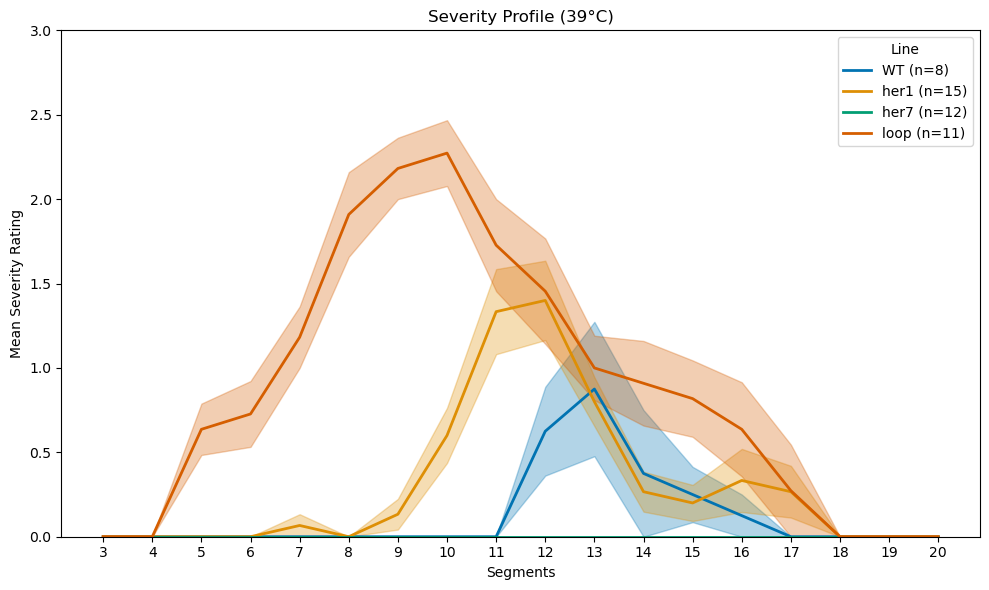

In [ ]:
# Columns 3–20
value_cols = [col for col in all_data.columns if isinstance(col, int) and 3 <= col <= 20]

conditions = all_data['Condition'].unique()


for cond in conditions:
    plt.figure(figsize=(10, 6))
    subset_cond = all_data[all_data['Condition'] == cond]

    for i, line in enumerate(lines):
        subset_line = subset_cond[subset_cond['Line'] == line]
        if subset_line.empty:
            continue

        n_embryos = len(subset_line)

        # Compute mean across embryos for each column
        mean_profile = subset_line[value_cols].mean(axis=0).values

        # Compute standard error for confidence interval
        sem_profile = subset_line[value_cols].sem(axis=0).values

        # Use seaborn.lineplot with x, y and error bars manually
        plt.plot(value_cols, mean_profile, label=f"{line} (n={n_embryos})", color=colors[i], linewidth=2)
        plt.fill_between(value_cols,
                         mean_profile - sem_profile,
                         mean_profile + sem_profile,
                         color=colors[i],
                         alpha=0.3)

    plt.ylim(0, 3)
    plt.title(f"Severity Profile ({cond})")
    plt.xlabel("Segments")
    plt.ylabel("Mean Severity Rating")
    plt.xticks(value_cols)
    plt.legend(title="Line")
    plt.tight_layout()
    plt.savefig(f'severity_profile_{cond}.png', dpi=600)
    plt.show()
